# <div align="center"><b>RNA-seq normalizations</b></div>

In [1]:
# Start by impor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path_counts = "/tscc/nfs/home/aklie/scratch/feature_counts/hangauer.results.counts"

# Load data

In [3]:
# Load counts
counts = pd.read_csv(path_counts, comment="#", sep="\t", index_col=0)
gene_info = counts.iloc[:, 0:5]
counts = counts.iloc[:, 5:]
counts.columns = [x.split("/")[-1].split(".")[0] for x in counts.columns]
counts.head()

,DMSO_1_ATCACGAligned,DMSO_2_CGATGTAligned,DTP_1_CAGATCAligned,DTP_2_CCGTCCAligned,DTP_3_GTGAAAAligned
Geneid,,,,,
ENSG00000223972.4,0,0,0,0,0
ENSG00000227232.4,16,19,44,38,61
ENSG00000243485.2,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0


In [4]:
counts = counts.rename(
    columns=
    {
        counts.columns[0]:"Parental1",
        counts.columns[1]:"Parental2",
        counts.columns[2]:"Persister1",
        counts.columns[3]:"Persister2",
        counts.columns[4]:"Persister3"
    }
)
counts.head()

,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000223972.4,0,0,0,0,0
ENSG00000227232.4,16,19,44,38,61
ENSG00000243485.2,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0


In [5]:
def normalize_rpkm(counts_matrix, gene_lengths):
    """
    Normalize an RNA-seq counts matrix using Reads Per Kilobase of transcript per Million mapped reads (RPKM).
    
    RPKM (Reads Per Kilobase of transcript per Million mapped reads) and FPKM (Fragments Per Kilobase 
    of transcript per Million mapped reads) normalize for both the length of the gene and the total 
    number of reads (i.e., the library size), making expression level comparisons between genes 
    in the same sample possible.
    
    Pros:
    - Widely used and established/incorporated in several software tools.
    - Makes it possible to compare gene expression levels within the same sample and between different samples.
    
    Cons:
    - Assumes that the total number of reads is the same across all samples, which isn't always accurate, 
      particularly when comparing different conditions or tissues.
    - Can be biased by highly expressed genes or transcripts, making it less reliable for datasets 
      with a high level of expression variation.
    - Like TPM, it cannot be used for differential expression analysis.
    
    Parameters:
    counts_matrix (pd.DataFrame): A pandas DataFrame containing raw read counts 
                                  with rows as genes and columns as samples.
    gene_lengths (pd.Series): A pandas Series containing the lengths of genes in kilobases.
                              The index should match the row index of the counts_matrix.
    
    Returns:
    pd.DataFrame: A pandas DataFrame with RPKM-normalized expression values.
    
    Raises:
    ValueError: If the input counts_matrix is not a pandas DataFrame or if gene_lengths is not a pandas Series.
    """
    
    if not isinstance(counts_matrix, pd.DataFrame):
        raise ValueError("counts_matrix must be a pandas DataFrame.")
    
    if not isinstance(gene_lengths, pd.Series):
        raise ValueError("gene_lengths must be a pandas Series.")
    
    if not all(counts_matrix.index == gene_lengths.index):
        raise ValueError("The index of counts_matrix and gene_lengths must match.")
    
    # Divide by both gene length and total counts, then multiply by 1e9 to get RPKM
    rpkm_matrix = counts_matrix.div(gene_lengths, axis=0).div(counts_matrix.sum(axis=0), axis=1) * 1e9
    
    return rpkm_matrix

In [6]:
# Get gene lengths
gene_lengths = gene_info["Length"]
gene_lengths.head()

Geneid
ENSG00000223972.4    1756
ENSG00000227232.4    2073
ENSG00000243485.2    1021
ENSG00000237613.2    1219
ENSG00000268020.2     947
Name: Length, dtype: int64

In [16]:
# Normalize counts using RPKM
rpkm = normalize_rpkm(counts, gene_lengths)
rpkm.head()

,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000223972.4,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232.4,0.165011,0.195817,0.493981,0.388435,0.676793
ENSG00000243485.2,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613.2,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000268020.2,0.000000,0.000000,0.000000,0.000000,0.000000


# Data visualization

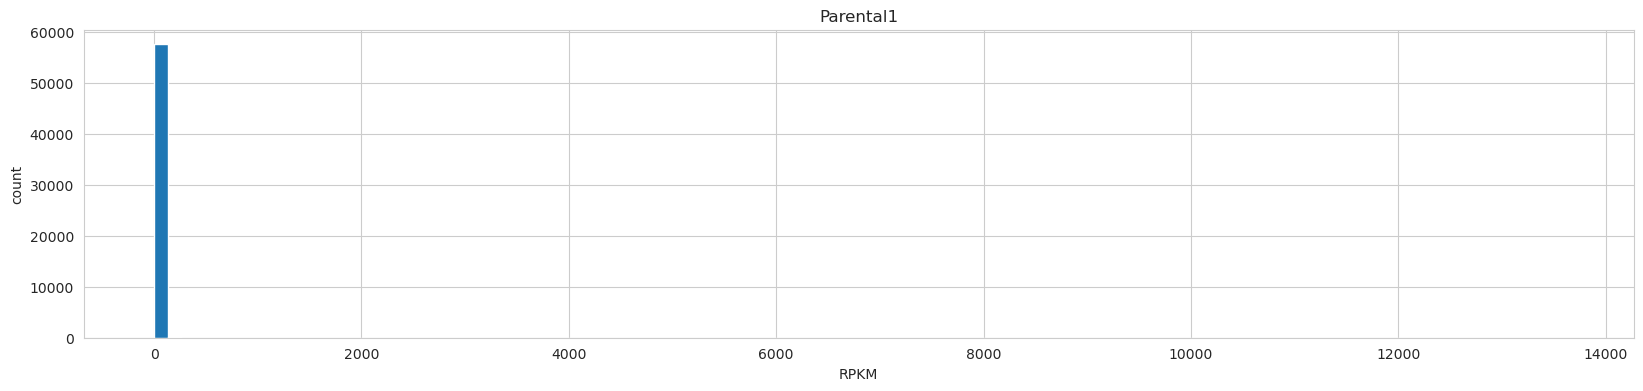

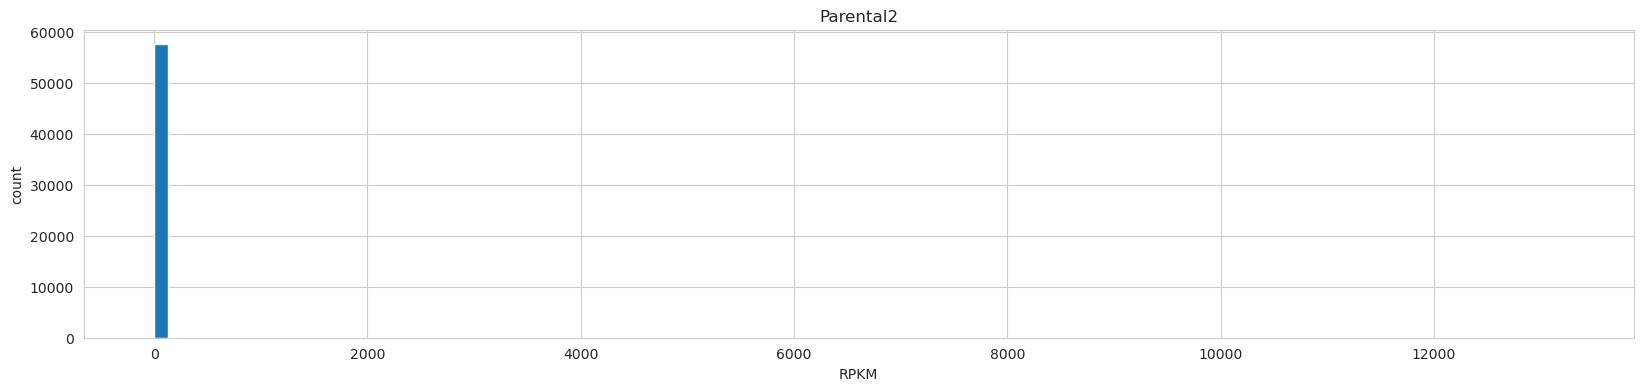

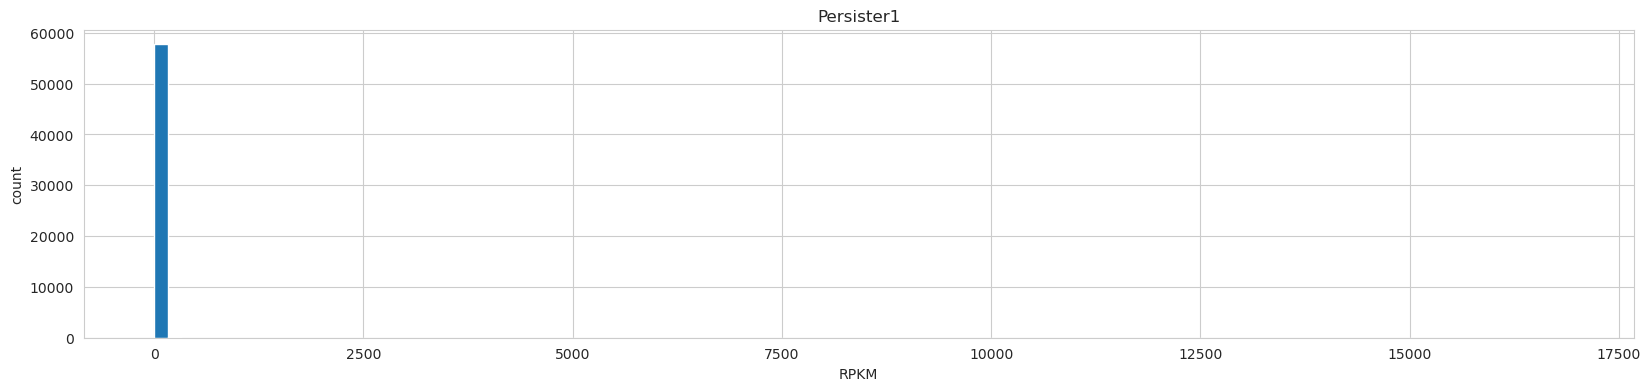

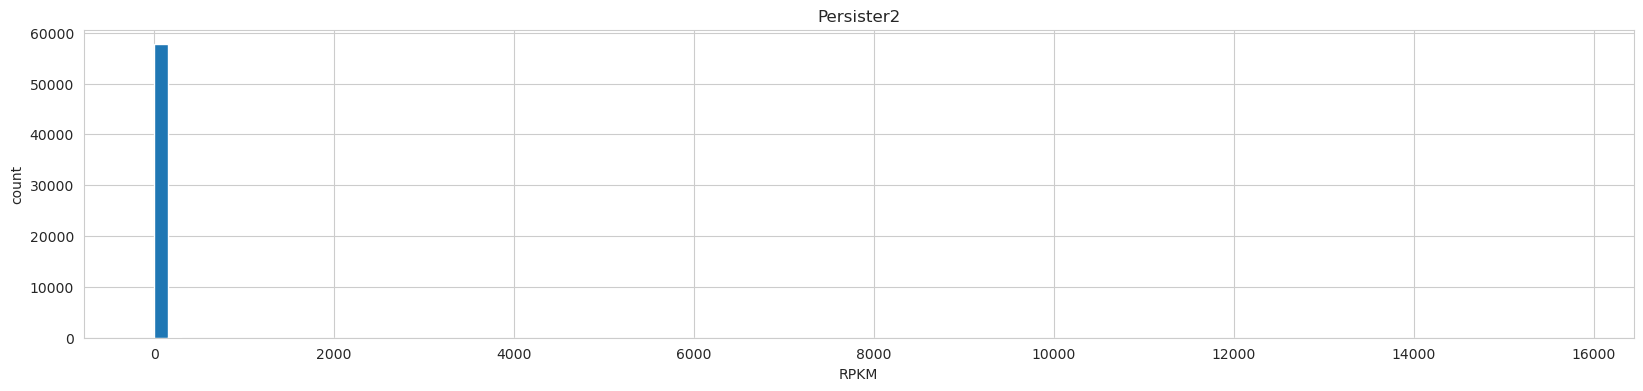

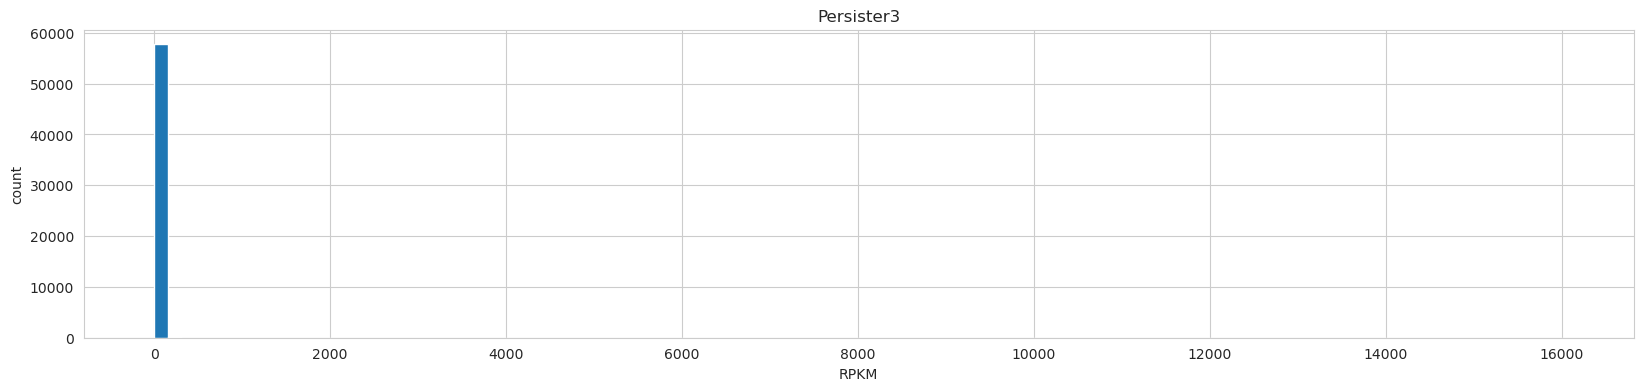

In [17]:
#Let's look at a histogram of the rpkm values for each sample.
sns.set_style("whitegrid")
for i in rpkm.columns:
    plt.figure(figsize=(20,4))
    plt.hist(rpkm[i], bins=100)
    plt.xlabel("RPKM")
    plt.ylabel("count")
    plt.title(i)

# Log transformation

In [19]:
#To get rid of a lot of noise, we are going to drop rows that have RPKM less than 4
rpkm_filtered = rpkm.loc[rpkm.sum(axis=1) > 4]
print(rpkm_filtered.shape)
rpkm_filtered.head()

(13331, 5)


,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000225972.1,3.563206,3.331043,2.377374,2.335474,2.163965
ENSG00000225630.1,1.883994,1.412030,1.515881,1.258419,1.321831
ENSG00000237973.1,25.494359,22.693852,37.692690,41.171801,34.864973
ENSG00000229344.1,7.805616,7.549668,9.759745,10.377584,8.734548
ENSG00000240409.1,0.929532,1.857793,1.124311,1.023679,1.444435


In [20]:
#Now let's take the log2RPKM. We will include a pseudocount to prevent inf values (i.e. log 0 == -inf /or undefined..)
rpkm_filtered +=1
rpkm_log2 = np.log2(rpkm_filtered)
print(rpkm_log2.shape)
rpkm_log2.head()

(13331, 5)


,Parental1,Parental2,Persister1,Persister2,Persister3
Geneid,,,,,
ENSG00000225972.1,2.190048,2.114715,1.755902,1.737892,1.661733
ENSG00000225630.1,1.528068,1.270248,1.331064,1.175313,1.215263
ENSG00000237973.1,4.727613,4.566441,5.273989,5.398207,5.164504
ENSG00000229344.1,3.138424,3.095868,3.427572,3.508122,3.283114
ENSG00000240409.1,0.948251,1.514901,1.086995,1.016981,1.289501


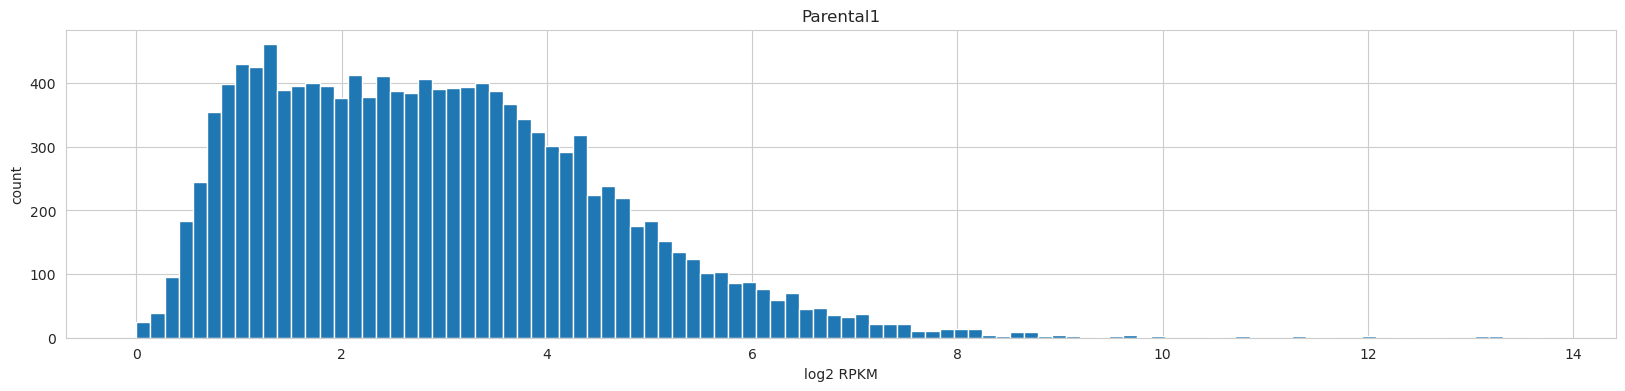

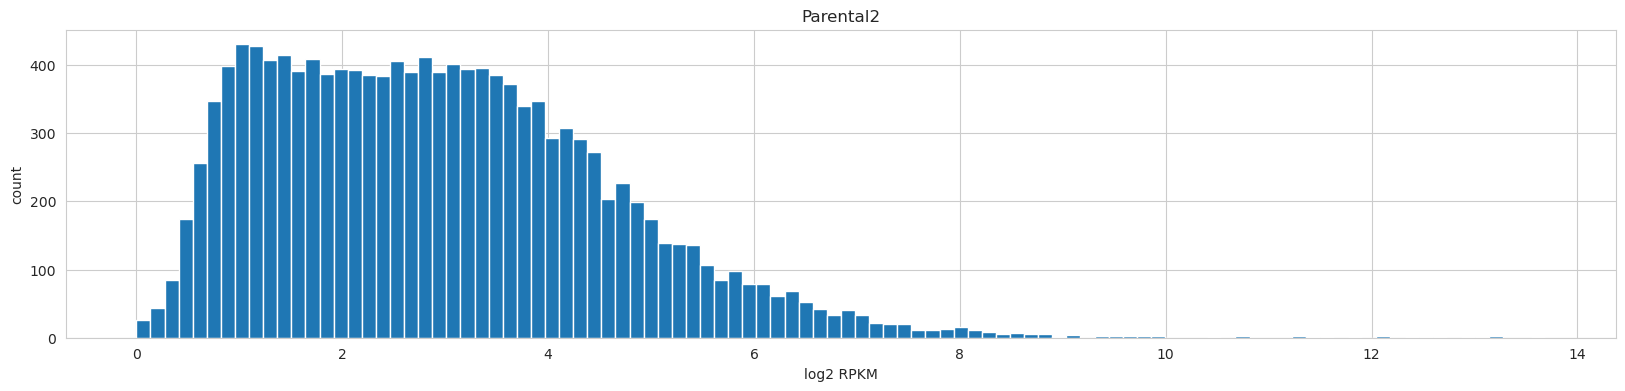

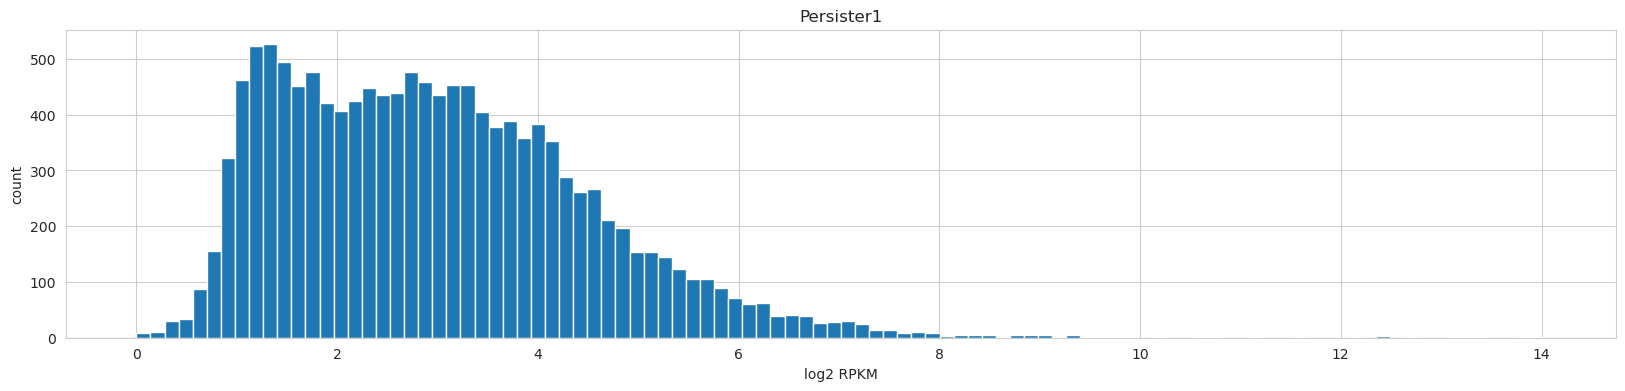

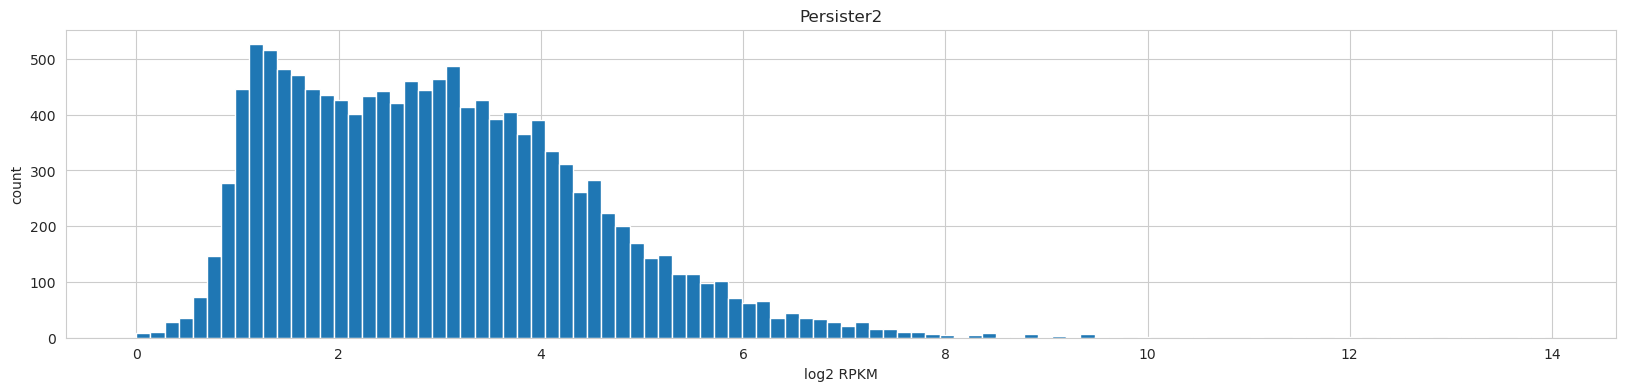

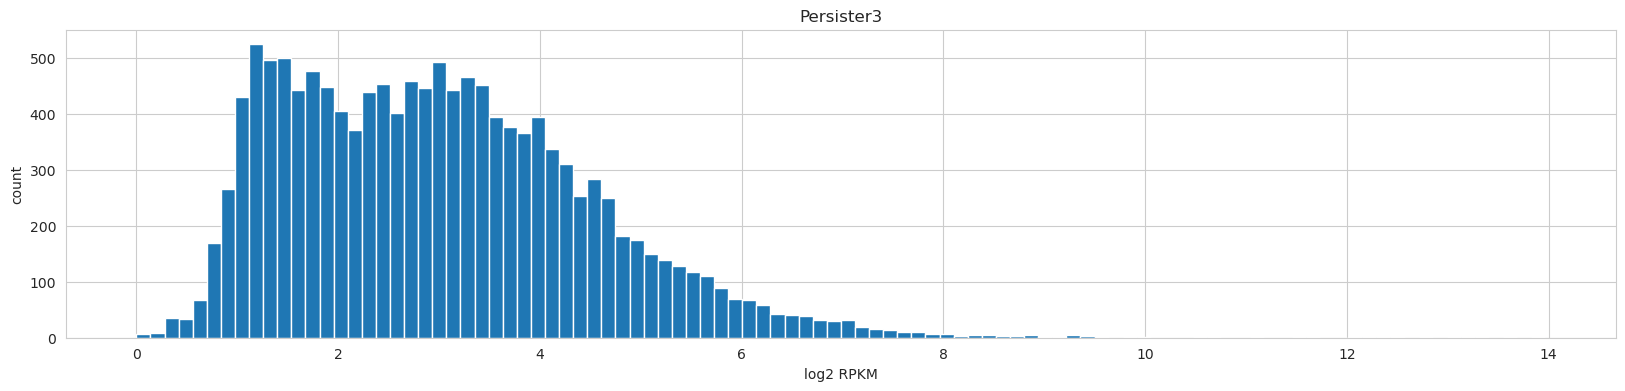

In [21]:
sns.set_style("whitegrid")
for i in rpkm_log2.columns:
    plt.figure(figsize=(20,4))
    plt.hist(rpkm_log2[i], bins=100)
    plt.xlabel("log2 RPKM")
    plt.ylabel("count")
    plt.title(i)

# Clustering

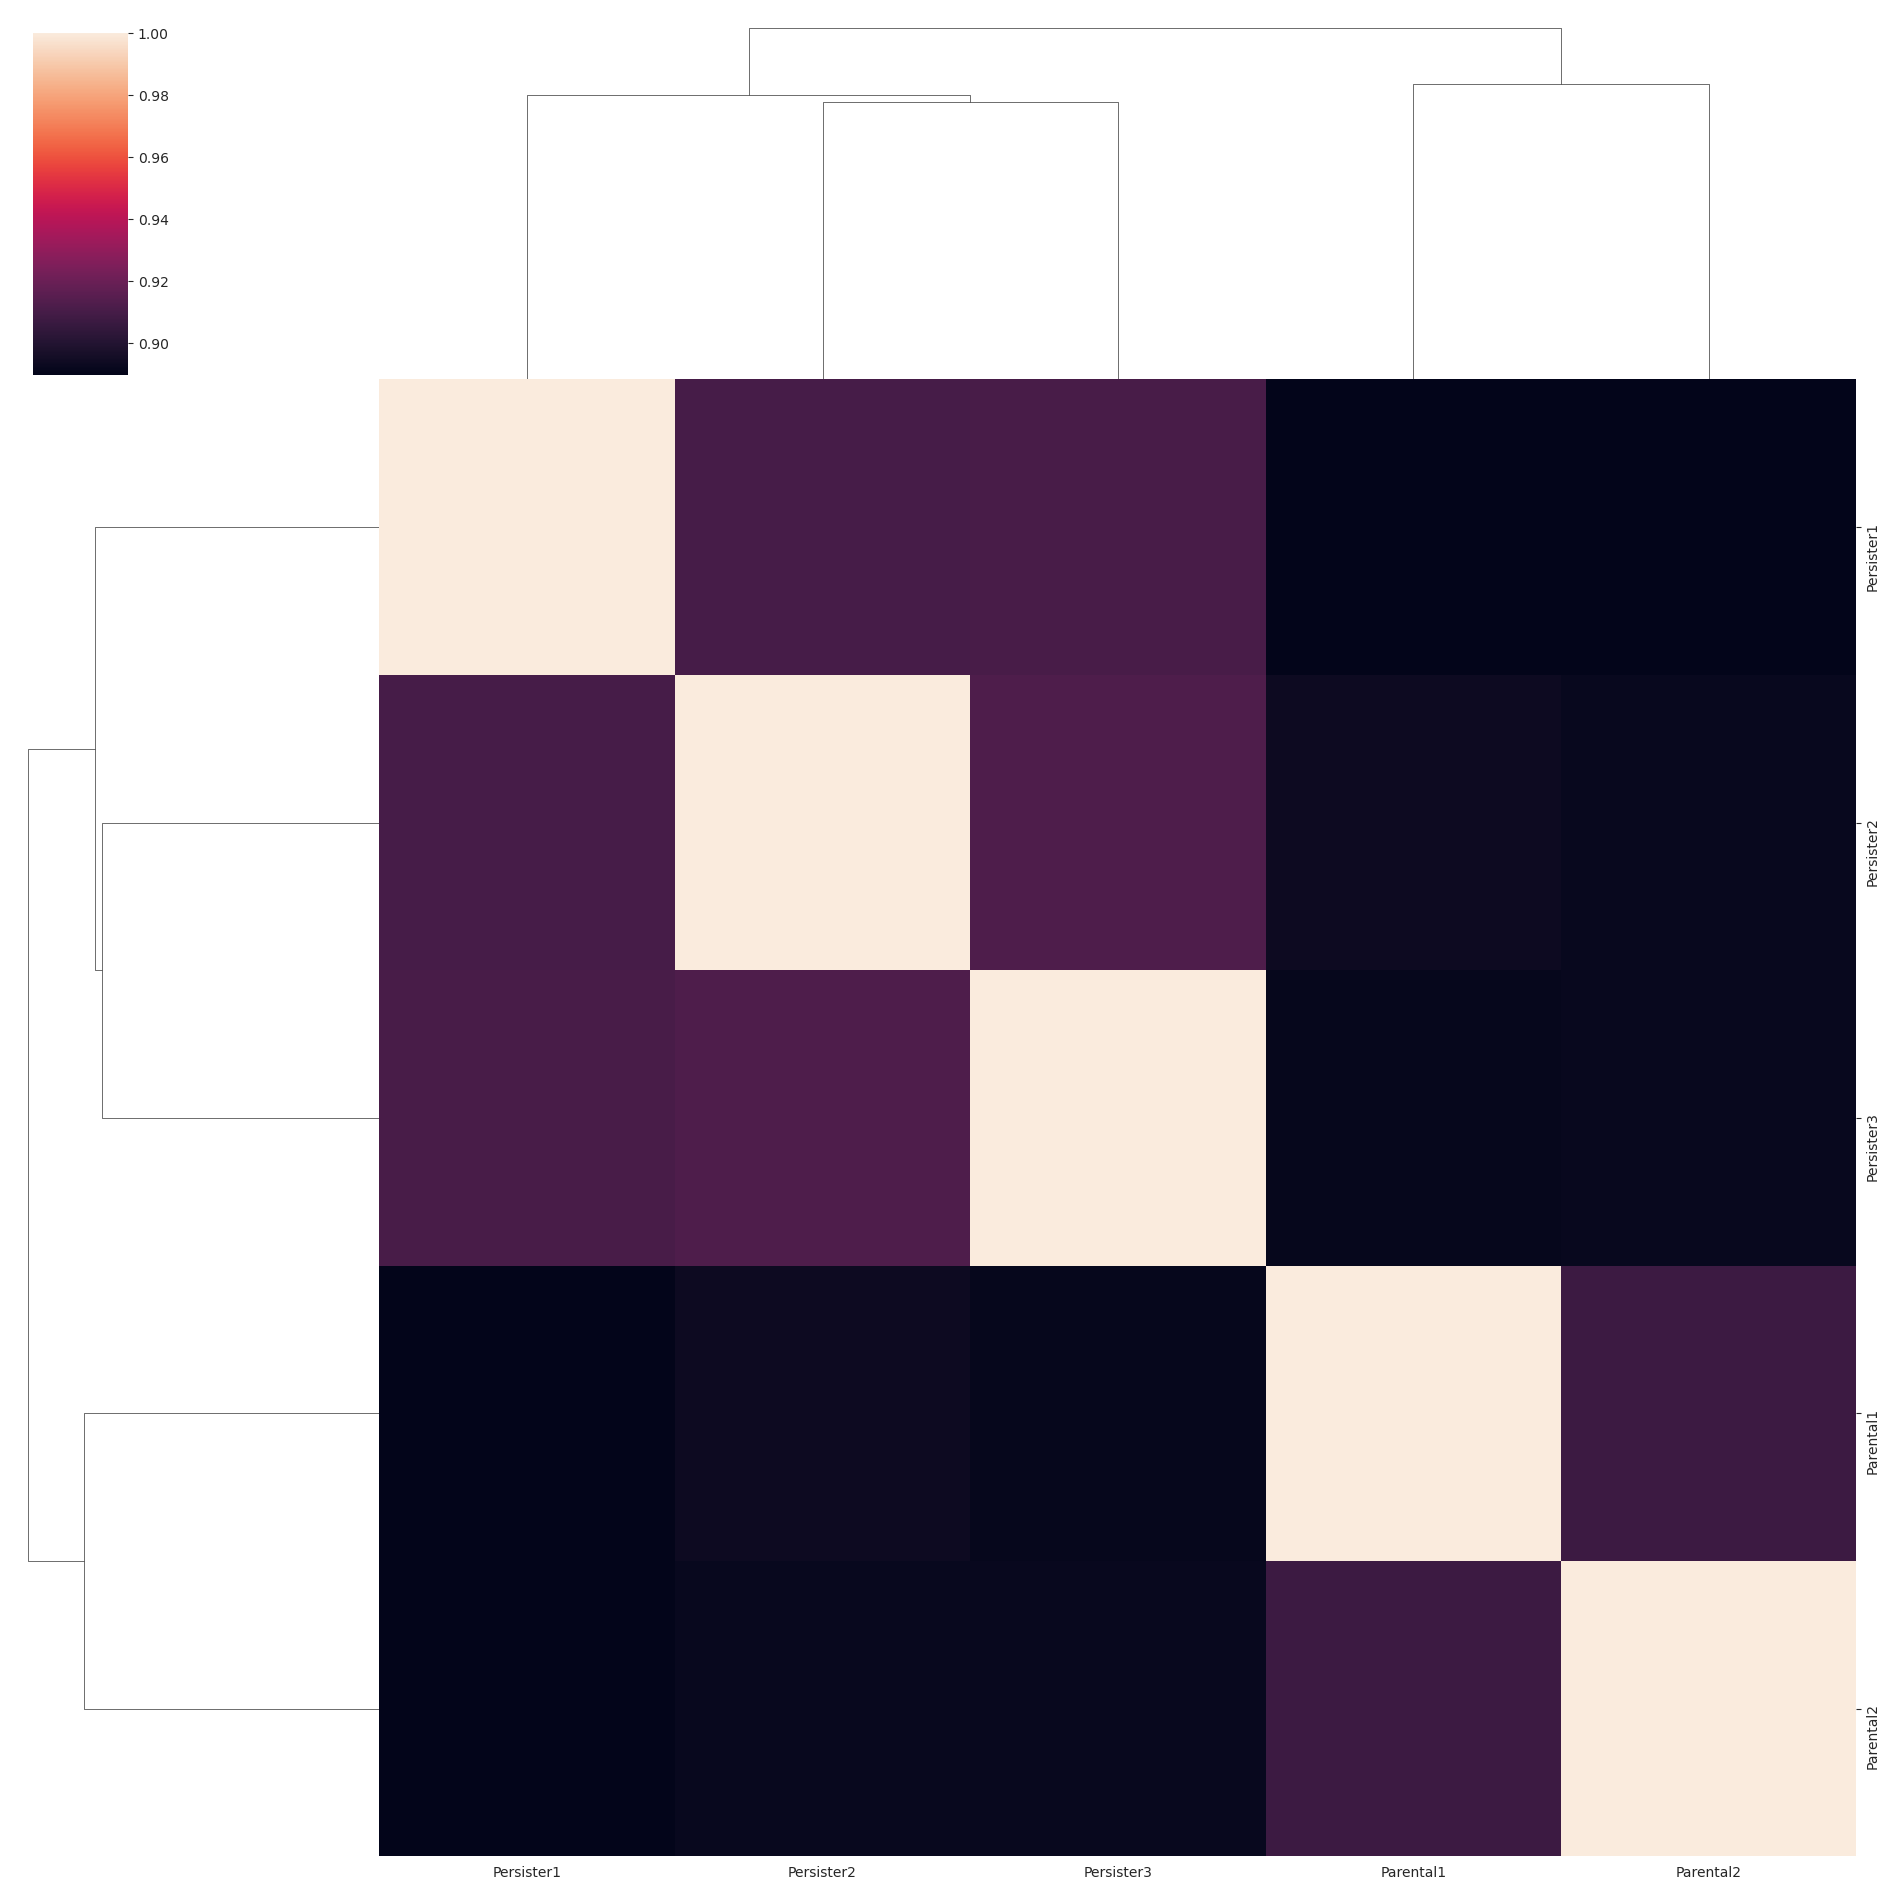

In [23]:
sns.clustermap(rpkm.corr(method='spearman'), figsize = (19,19))

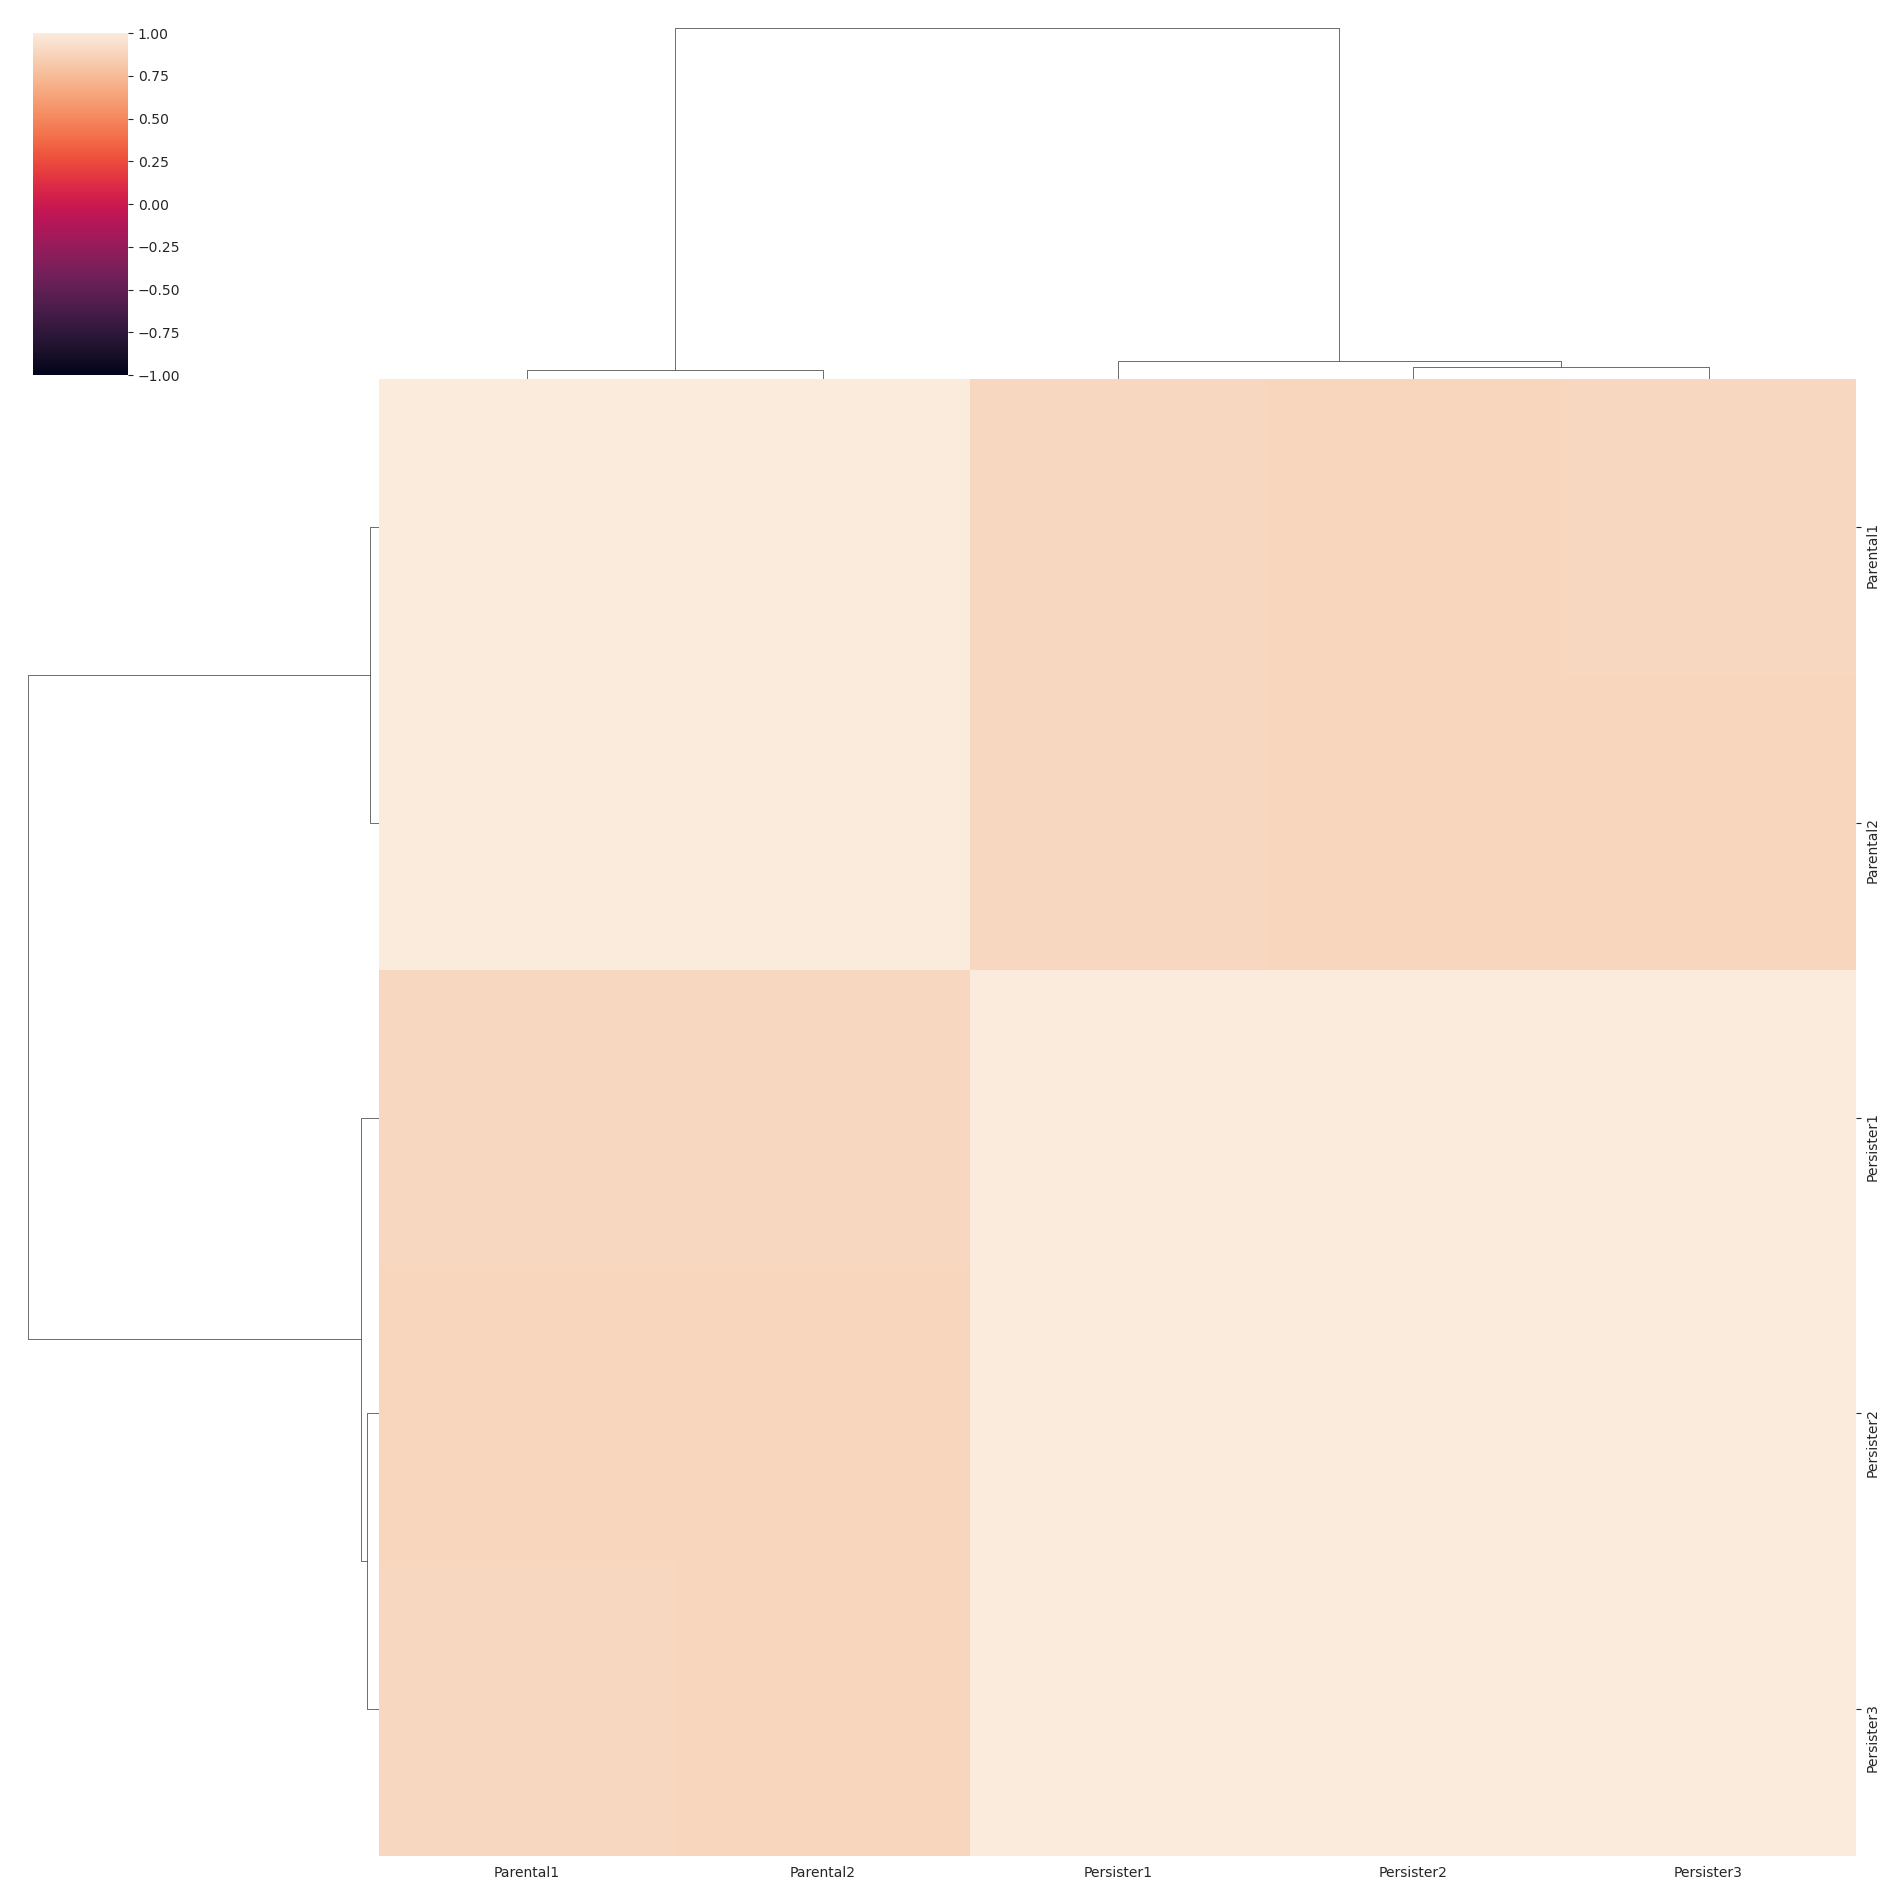

In [24]:
sns.clustermap(rpkm_filtered.corr(method='spearman'),vmin=-1,vmax=1, figsize = (19,19))

# DONE!

---